## Access Radar Velocity hourly average delayed QC At Turquoise Coast data in Zarr
A jupyter notebook to show how to access and plot the AODN radar_TurquoiseCoast_velocity_hourly_average_delayed_qc dataset available as a [Zarr](https://zarr.dev/)  dataset on S3

In [1]:
dataset_name="radar_TurquoiseCoast_velocity_hourly_average_delayed_qc"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 230 packages in 29ms


In [3]:
import requests
import os
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [4]:
from parquet_queries import plot_gridded_variable, create_timeseries, plot_time_coverage

In [5]:
import xarray as xr
import fsspec

In [6]:
# remote zarr dataset
url = f's3://imos-data-lab-optimised/cloud_optimised/cluster_testing/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)
ds

<xarray.Dataset> Size: 807MB
Dimensions:               (I: 60, J: 59, TIME: 7127)
Coordinates:
  * I                     (I) int32 240B 1 2 3 4 5 6 7 ... 54 55 56 57 58 59 60
  * J                     (J) int32 236B 1 2 3 4 5 6 7 ... 53 54 55 56 57 58 59
    LATITUDE              (I, J) float64 28kB dask.array<chunksize=(59, 59), meta=np.ndarray>
    LONGITUDE             (I, J) float64 28kB dask.array<chunksize=(59, 59), meta=np.ndarray>
  * TIME                  (TIME) datetime64[ns] 57kB 2020-01-01 ... 2020-12-3...
Data variables:
    GDOP                  (I, J) float32 14kB dask.array<chunksize=(59, 59), meta=np.ndarray>
    NOBS1                 (TIME, I, J) float32 101MB dask.array<chunksize=(1000, 59, 59), meta=np.ndarray>
    NOBS2                 (TIME, I, J) float32 101MB dask.array<chunksize=(1000, 59, 59), meta=np.ndarray>
    UCUR                  (TIME, I, J) float32 101MB dask.array<chunksize=(1000, 59, 59), meta=np.ndarray>
    UCUR_quality_control  (TIME, I, J) float32 101MB dask.array<chunksize=(1000, 59, 59), meta=np.ndarray>
    UCUR_sd               (TIME, I, J) float32 101MB dask.array<chunksize=(1000, 59, 59), meta=np.ndarray>
    VCUR                  (TIME, I, J) float32 101MB dask.array<chunksize=(1000, 59, 59), meta=np.ndarray>
    VCUR_quality_control  (TIME, I, J) float32 101MB dask.array<chunksize=(1000, 59, 59), meta=np.ndarray>
    VCUR_sd               (TIME, I, J) float32 101MB dask.array<chunksize=(1000, 59, 59), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      The IMOS Ocean Radar Facility is producing...
    acknowledgement:               Any users (including re-packagers) of IMOS...
    author:                        Cosoli, Simone; Hetzel, Yasha
    author_email:                  simone.cosoli@uwa.edu.au; yasha.hetzel@uwa...
    citation:                      The citation in a list of references is: I...
    ...                            ...
    source:                        Terrestrial HF radar
    ssr_Stations:                  Lancelin (LANC), Green Head (GHED)
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2020-12-26T17:00:00Z
    time_coverage_start:           2020-12-26T17:00:00Z
    title:                         IMOS Ocean Radar Facility Turqoise Coast (...

## Plot time coverage

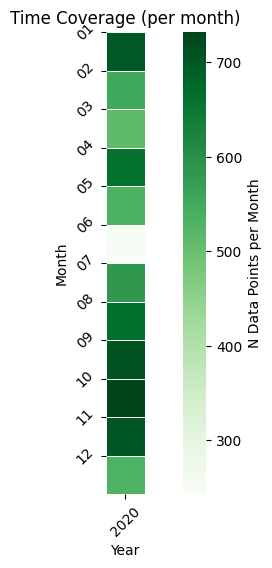

In [7]:
plot_time_coverage(ds, time_var="TIME")

In [8]:
## Plot a gridded variable

In [9]:
from matplotlib.pyplot import figure, pcolor, colorbar, xlabel, ylabel, title, draw, quiver, show
import matplotlib.pyplot as plt
import numpy as np

def acorn_plot(ds, time_start):
    """
    Plotting function for ACORN data.

    Parameters:
    - ds: xarray dataset
        The input dataset.
    - time_start: str
        The starting time in the format '2021-02-21T01:00:00'.
    """
    ds = ds.sortby("TIME")

    # Create a 3x2 grid of subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

    # Plot data on each subplot. We're plotting the next 6 time stamps (requiring obviously that they all exist)
    ii = 0
    iTime = list(ds.TIME.values).index(ds.sel(TIME=time_start , method='nearest').TIME)
    cbar_ax = fig.add_axes([0.99, 0.1, 0.02, 0.8])  # Adjust the position and size of the colorbar

    for i in range(3):
        for j in range(2):
            uData = ds.UCUR[iTime + ii, :, :]
            vData = ds.VCUR[iTime + ii, :, :]
            speed = np.sqrt(uData**2 + vData**2)
            lonData = ds.LONGITUDE.values
            latData = ds.LATITUDE.values

            p = axes[i, j].pcolor(lonData, latData, speed)
            axes[i, j].quiver(lonData, latData, uData, vData, units='width')
            axes[i, j].set_title(f'{np.datetime_as_string(ds.TIME.values[iTime + ii])}')
            ii += 1

    # Add a common colorbar
    fig.colorbar(p, cax=cbar_ax, label='Speed')

    # Adjust layout for better appearance
    plt.tight_layout()

    # Show the plot
    plt.show()

/tmp/ipykernel_1739507/1112413647.py:33: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  p = axes[i, j].pcolor(lonData, latData, speed)
/tmp/ipykernel_1739507/1112413647.py:33: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  p = axes[i, j].pcolor(lonData, latData, speed)
/tmp/ipykernel_1739507/1112413647.py:33: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  p = axes[i, j].pcolor(lonData, latData, speed)
/tmp

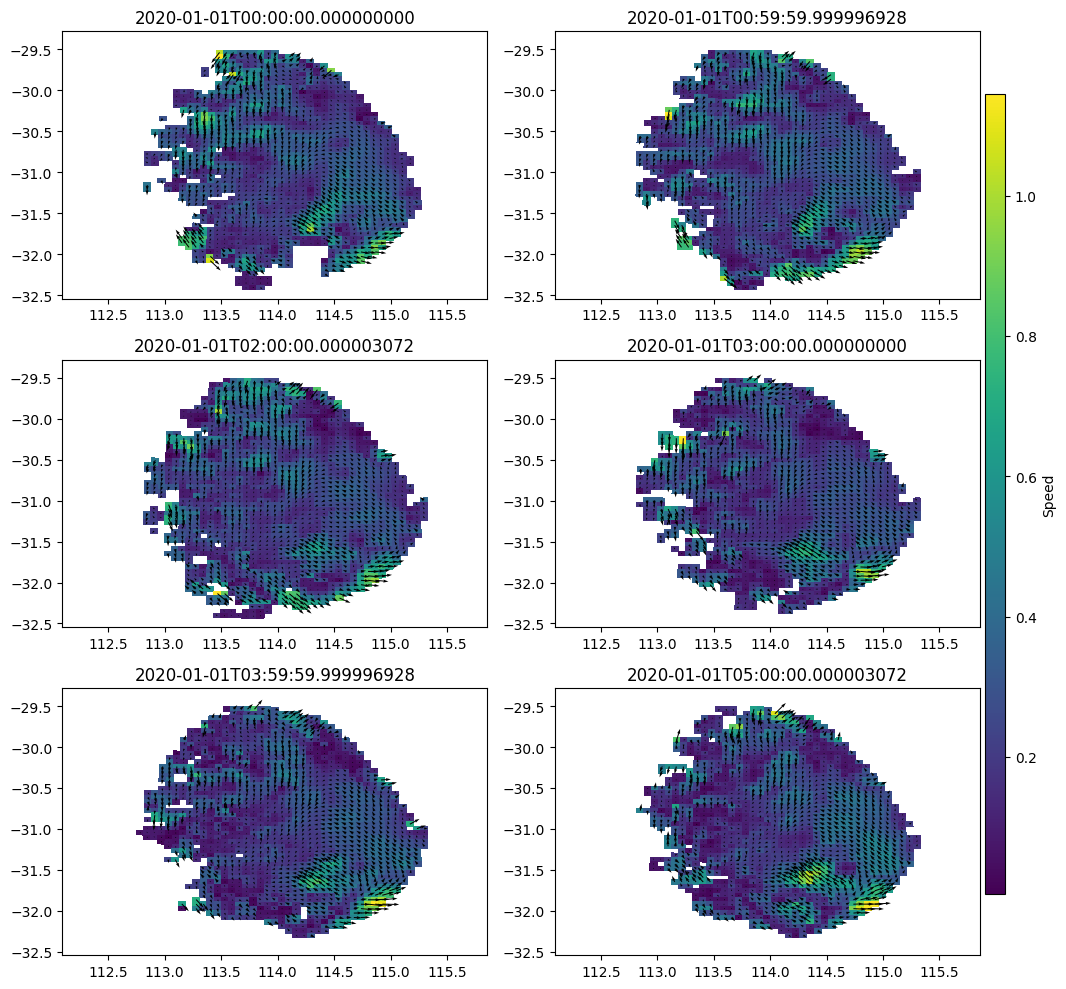

CPU times: user 2.69 s, sys: 1.24 s, total: 3.93 s
Wall time: 18.9 s


In [10]:
%%time
acorn_plot(ds, '2020-01-01T00:00:00')